In [ ]:
"""
코퍼스 (분석 대상 분야 문서 집합)
코퍼스에 존재하지 않는 단어 : OutOfVocabulary (OOV)
"""

import numpy as np 
from numpy.linalg import norm # norm: vector의 크기 
from numpy import dot # dot:두 vector의 내적을 구하는 함수
# DTM
#     바나나      사과       저는         좋아요
# d1      0        1          1             1
# d2      1        0          1             1
# d3      2        0          2             2
doc1=np.array([0,1,1,1])
doc2=np.array([1,0,1,1])
doc3=np.array([2,0,2,2])
dot(doc1, doc2) # 두 벡터의 내적
norm(doc1)

In [3]:
import pandas as pd

data = pd.read_csv("movies_metadata.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [4]:
data = data.head(20000)

In [7]:
data['overview'].isnull().sum()

135

In [9]:
data['overview'] = data['overview'].fillna('')
data['overview'].isnull().sum()

0

In [11]:
# TFIDF구하기
from sklearn.feature_extraction.text import TfidfVectorizer

Tfidf = TfidfVectorizer(stop_words='english')
TfidfMatrix = Tfidf.fit_transform(data['overview'])
# tfidfv = TfidfVectorizer().fit(corpus)
# a = tfidfv.transform(corpus).toarray()
# pd.DataFrame(a, columns = sorted(tfidfv.vocabulary_.keys()))

In [15]:
TfidfMatrix.shape
TfidfMatrix

<20000x47487 sparse matrix of type '<class 'numpy.float64'>'
	with 535909 stored elements in Compressed Sparse Row format>

In [16]:
from sklearn.metrics.pairwise import linear_kernel

cos_sim = linear_kernel(TfidfMatrix, TfidfMatrix)

In [19]:
cos_sim.shape
cos_sim

array([[1.        , 0.01575748, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.01575748, 1.        , 0.04907345, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04907345, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.08375766],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.08375766, 0.        ,
        1.        ]])

In [ ]:
# 1. Toy Story 영화제목 입력
# 2. Toy Story 코사인유사도가 가장 높은 영화 제목 추출

In [25]:
data[['title','genres']].duplicated().sum()

104

In [28]:
indices = pd.Series(data.index, index=data['title']).drop_duplicates()
print(indices.head())

title
Toy Story                      0
Jumanji                        1
Grumpier Old Men               2
Waiting to Exhale              3
Father of the Bride Part II    4
dtype: int64


In [23]:
df = pd.DataFrame({'k1' : ['a','b','b','c','b','c']})
df.duplicated(['k1'])

0    False
1    False
2     True
3    False
4     True
5     True
dtype: bool

In [58]:
def getRecommendation(title, cosine_sim= cos_sim):
    idx = indices[title]
    simScores = list(enumerate(cosine_sim[idx])) #코사인유사도
    simScores = sorted(simScores, key=lambda x: x[1] ,reverse=True)
    simScores = simScores[1:21]
    movieidx = [i[0] for i in simScores]
    return data['title'].iloc[movieidx]

In [59]:
getRecommendation("Toy Story")

15348                                    Toy Story 3
2997                                     Toy Story 2
10301                         The 40 Year Old Virgin
8327                                       The Champ
1071                           Rebel Without a Cause
11399                         For Your Consideration
1932                                       Condorman
3057                                 Man on the Moon
485                                           Malice
11606                                   Factory Girl
17189                                      Group Sex
7254                                  Africa Screams
5797                                   Class of 1984
13947                            The Gang's All Here
1032                                   The Sunchaser
3252                                 Bound for Glory
2157                               Indecent Proposal
7615     The First $20 Million Is Always the Hardest
6944                                Rivers and

In [ ]:
# 영화 리뷰 분류 (이진분류)

In [61]:
from keras.datasets import imdb

(traindata, trainlabels),(testdata, testlabels) = imdb.load_data(num_words=10000) #자주 사용되는 단어 10000개만 추려서 사용

In [65]:
traindata.shape # 25000개 훈련데이터 (리뷰)
trainlabels.shape # 0:부정, 1:긍정
testdata.shape

(25000,)

In [68]:
maxseq = [max(seq) for seq in traindata]
max(maxseq)

9999

In [76]:
word_index = imdb.get_word_index() #(단어,인덱스)
reverse_word_index = dict([(value , key) for (key,value) in word_index.items()]) #(인덱스,단어)

In [86]:
reverse_word_index
traindata[0]
reverse_word_index[1]
print(reverse_word_index.get(1000000, "?")) # 만약 인덱스가 1000000이 존재하지 않는다면 ?로 대체해라
# 0,1,2는 "패딩", "문서시작", "사전에 없음(oov)"
# 을 인덱스로 약속되어 사용됨 / 따라서 012는 제외
# 위 3개는 물음표 문자로 대체
decodedReview = " ".join(reverse_word_index.get(i-3,"?") for i in traindata[0])

?


In [87]:
decodedReview

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

In [ ]:
""" 
패딩 : 문장의 길이가 다름 -> 문장의 길이를 동일하게 해줌 
신경망 모델을 만들기 위해서는 먼저 패딩을 수행하여 모든 문장의 길이를 동일하게 해줘야 함.  
"""

In [141]:
sentences = [['barber', 'person'], ['barber', 'good', 'person'], ['barber', 'huge', 'person'], ['knew', 'secret'], ['secret', 'kept', 'huge', 'secret'], ['huge', 'secret'], ['barber', 'kept', 'word'], ['barber', 'kept', 'word'], ['barber', 'kept', 'secret'], ['keeping', 'keeping', 'huge', 'secret', 'driving', 'barber', 'crazy'], ['barber', 'went', 'huge', 'mountain']]

In [142]:
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer()
tok.fit_on_texts(sentences)
# 빈도수를 기준으로 단어집합 생성

In [143]:
tok.word_index
# tok.word_index
# tok.word_counts
# tok.word_docs

{'barber': 1,
 'secret': 2,
 'huge': 3,
 'kept': 4,
 'person': 5,
 'word': 6,
 'keeping': 7,
 'good': 8,
 'knew': 9,
 'driving': 10,
 'crazy': 11,
 'went': 12,
 'mountain': 13}

In [144]:
encoded = tok.texts_to_sequences(sentences)
encoded # 이상태에서 패딩을 해줘야함

[[1, 5],
 [1, 8, 5],
 [1, 3, 5],
 [9, 2],
 [2, 4, 3, 2],
 [3, 2],
 [1, 4, 6],
 [1, 4, 6],
 [1, 4, 2],
 [7, 7, 3, 2, 10, 1, 11],
 [1, 12, 3, 13]]

In [145]:
maxLen = max(len(item) for item in encoded) #7

In [146]:
# 제로패딩

for item in encoded:
    while len(item)<maxLen:
        item.append(0)
padded_np = np.array(encoded)
padded_np

array([[ 1,  5,  0,  0,  0,  0,  0],
       [ 1,  8,  5,  0,  0,  0,  0],
       [ 1,  3,  5,  0,  0,  0,  0],
       [ 9,  2,  0,  0,  0,  0,  0],
       [ 2,  4,  3,  2,  0,  0,  0],
       [ 3,  2,  0,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  2,  0,  0,  0,  0],
       [ 7,  7,  3,  2, 10,  1, 11],
       [ 1, 12,  3, 13,  0,  0,  0]])

In [147]:
# 케라스에서 제로패딩 한번에 해주는 함수
from tensorflow.keras.preprocessing.sequence import pad_sequences
sentences
encoded = tok.texts_to_sequences(sentences) # 각단어를 단어의인덱스로 치환
padded = pad_sequences(encoded, padding='post')
padded

array([[ 1,  5,  0,  0,  0,  0,  0],
       [ 1,  8,  5,  0,  0,  0,  0],
       [ 1,  3,  5,  0,  0,  0,  0],
       [ 9,  2,  0,  0,  0,  0,  0],
       [ 2,  4,  3,  2,  0,  0,  0],
       [ 3,  2,  0,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  6,  0,  0,  0,  0],
       [ 1,  4,  2,  0,  0,  0,  0],
       [ 7,  7,  3,  2, 10,  1, 11],
       [ 1, 12,  3, 13,  0,  0,  0]])

In [148]:
(traindata,trainlabels),(testdata,testlabels)=imdb.load_data(num_words=10000)

In [149]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension)) #25000행, 10000열이 0으로 구성
    for i, seq in enumerate(sequences):
        print(i,"번 리뷰:",seq)
        results[i,seq] = 1
    return results

xtrain = vectorize_sequences(traindata)
xtest = vectorize_sequences(testdata)

, 9, 24, 6, 1361, 237, 4, 1472, 248, 3230, 374, 9237, 5, 857, 32, 202, 14, 245, 21, 39, 14, 1573, 606, 863, 6, 1238, 1315, 3696, 297, 9600, 5, 4, 836, 266, 39, 406, 876, 5, 4, 1729, 7, 84, 247, 74, 6, 1019, 8194, 160, 232, 261, 14, 9, 35, 1427, 11, 4, 22, 198, 51, 166, 4, 2714, 6405, 38, 52, 10, 10, 46, 7, 470, 381]
24982 번 리뷰: [1, 13, 377, 149, 14, 22, 11, 5697, 54, 13, 16, 693, 12, 16, 427, 530, 13, 258, 4, 288, 43, 6, 378, 7, 1928, 596, 13, 16, 754, 3583, 56, 5, 180, 19, 9283, 13, 1247, 12, 5, 1177, 12, 8, 61, 362, 36, 447, 12, 99, 36, 1803, 51, 715, 4, 16, 1118, 13, 161, 376, 98, 151, 88, 13, 92, 104, 979, 4, 715, 2, 5, 2, 8, 1086, 291, 154, 362, 9, 55, 52, 2, 4, 690, 26, 530, 13, 131, 377, 98, 32, 637, 131, 377, 98, 54, 146, 3293, 50, 42, 751, 2, 4044, 9, 16, 141, 6, 530, 284, 45, 6, 2240, 29, 520, 12, 56, 10, 10, 48, 25, 169, 4, 22, 818, 12, 490, 119, 12]
24983 번 리뷰: [1, 13, 424, 825, 2, 9, 6, 753, 1179, 509, 422, 12, 28, 49, 52, 213, 21, 45, 6, 7319, 39, 160, 509, 4, 1421, 9, 38

In [150]:
trainlabels # 25000개 리뷰가 긍정인지 부정인지

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

In [151]:
# zeros예시
np.zeros((3,2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

In [152]:
ytrain = np.asarray(trainlabels).astype('float32')
ytrain
ytest = np.asarray(testlabels).astype('float32')
ytest

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [153]:
from keras import models, layers

model = models.Sequential() # 무조건 이것부터 시작해! 이게 모델이야
######## 모델에 입력,히든,출력계층 추가 ########
# 입력계층 추가
model.add(layers.Dense(16, input_shape=(10000,), activation='relu'))
                        #모델에다가 계층 1개를 추가한다 (출력노드 16, 입력노드 10000)
# 히든계층 추가
model.add(layers.Dense(16, activation='relu'))
                        #모델에다가 계층 1개 더 추가 (출력노드 16, 입력노드 생략)
# 출력계층 추가
model.add(layers.Dense(1, activation='sigmoid'))
                        #모델에다가 계층 1개 더 추가 (출력노드 16, 입력노드 생략, 출력 : sigmoid)

In [154]:
model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [155]:
xval = xtrain[:10000]
pxtrain = xtrain[10000:]
yval = ytrain[:10000]
pytrain = ytrain[10000:]

# pxtrain, pytrain 훈련데이터
# xval, yval 검증데이터

In [156]:
history = model.fit(pxtrain, pytrain, epochs=30, batch_size=512, validation_data=(xval,yval))

Epoch 1/30
30/30 [==============================] - 1s 27ms/step - loss: 0.4954 - accuracy: 0.7948 - val_loss: 0.3736 - val_accuracy: 0.8647
Epoch 2/30
30/30 [==============================] - 1s 26ms/step - loss: 0.2911 - accuracy: 0.9021 - val_loss: 0.2996 - val_accuracy: 0.8878
Epoch 3/30
30/30 [==============================] - 1s 23ms/step - loss: 0.2151 - accuracy: 0.9303 - val_loss: 0.2794 - val_accuracy: 0.8891
Epoch 4/30
30/30 [==============================] - 1s 26ms/step - loss: 0.1708 - accuracy: 0.9445 - val_loss: 0.2988 - val_accuracy: 0.8803
Epoch 5/30
30/30 [==============================] - 1s 24ms/step - loss: 0.1413 - accuracy: 0.9554 - val_loss: 0.3157 - val_accuracy: 0.8764
Epoch 6/30
30/30 [==============================] - 1s 28ms/step - loss: 0.1148 - accuracy: 0.9649 - val_loss: 0.3285 - val_accuracy: 0.8743
Epoch 7/30
30/30 [==============================] - 1s 27ms/step - loss: 0.0950 - accuracy: 0.9722 - val_loss: 0.3633 - val_accuracy: 0.8681
Epoch 8/30
30

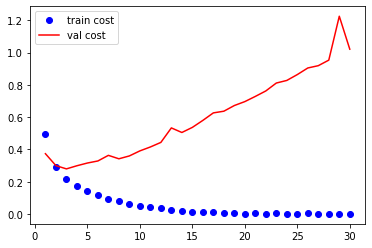

In [157]:
histDict = history.history
histDict.keys()
# history.history['loss']

import matplotlib.pyplot as plt
plt.plot(range(1,len(history.history['accuracy'])+1),history.history['loss'],'bo',label='train cost')
plt.plot(range(1,len(history.history['accuracy'])+1),history.history['val_loss'],'r',label='val cost')
plt.legend()

In [161]:
# 4번에폭
history = model.fit(xtrain, ytrain, epochs=4, batch_size=512)

Epoch 1/4
49/49 [==============================] - 0s 10ms/step - loss: 0.2496 - accuracy: 0.9448
Epoch 2/4
49/49 [==============================] - 1s 13ms/step - loss: 0.1314 - accuracy: 0.9614
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.0976 - accuracy: 0.9704
Epoch 4/4
49/49 [==============================] - 1s 11ms/step - loss: 0.0726 - accuracy: 0.9785


In [162]:
# 모델평가
res = model.evaluate(xtest,ytest)
res

782/782 [==============================] - 1s 1ms/step - loss: 0.5011 - accuracy: 0.8578


[0.5011076331138611, 0.8578000068664551]

In [163]:
model.predict(xtest)

array([[0.01590753],
       [1.        ],
       [0.9410845 ],
       ...,
       [0.06100616],
       [0.0724819 ],
       [0.35904616]], dtype=float32)